<a href="https://colab.research.google.com/github/JacobCrown/.NET_JAVA/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wstęp
Laboratorium 5 stanowi wprowadzenie w tematykę sieci konwolucyjnych. Sieci te wykorzystują, jak sama nazwa wskazuje, operację konwolucji (splotu) co pozwala na uwzględnienie informacji o lokalnym sąsiedztwie przestrzennym w przetwarzanych danych. W przypadku obrazów, jest to sąsiedztwo pikseli w dwuwymiarowej przestrzeni obrazu.

# Cel  ćwiczenia

Celem ćwiczenia jest zapoznianie z:

*   operacją konwolucji 2D i jej implementacją w torchu
*   warstwami konwolucyjnymi i ich parametrami
*   operacjami poolingu
*   prostymi sieciami konwolucyjnymi w klasyfikacji obrazu

# Konwolucja 2D

Najpierw wprowadzimy operację konwolucji. Konwolucja 2D przyjmuje na wejściu tensory o kształcie `(B,C,H,W)` - batch, channel, width, height. Kanały nazywamy też *mapami cech*, jako że w warstwach innych niż wejściowa są to w dalszym ciągu dwuwymiarowe "obrazki", ale odpowiadające już nie wprost kanałom RGB, ale pewnym cechom wydobywanym z mapy cech na wejściu przez uczące się filtry.

Tensor filtrów ma wymiary `(I,O,H,W)` - liczba kanałów warstwy wejściowej, liczba kanałów warstwy wyjściowej, wysokość i szerokość filtra. Możemy pomyśleć o tym przez analogię z warstwą w pełni połączoną: tam, element tensora wag `weights[i,j]` był jedną liczbą i odpowiadał połączeniu i-tego wejścia do j-tego wyjścia. W konwolucji, `weights[i,j]`  będzie odpowiadać połączeniu i-tej mapy cech do j-tej mapy cech, będzie jednak całą macierzą, ponieważ dla każdego połączenia we-wy map cech uczymy dwuwymiarowego filtra.

Dla przykładu, zaimplementujmy filtr rozmywający obraz RGB - każdy kanał z osobna. Filtr rozmywający jeden kanał definiuje `filter`, a ponieważ chcemy uzyskać połączenie tylko kanałów wejściowych do wyjściowych: R do R, G do G, B do B, a ponieważ dla każdego z tych połączeń filtr będzie taki sam, możemy po prostu wymnożyć go przez tensor `(3,3,1,1)`, utworzony z macierzy jednostkowej. W torchu taką macierz zwraca metoda `eye`.

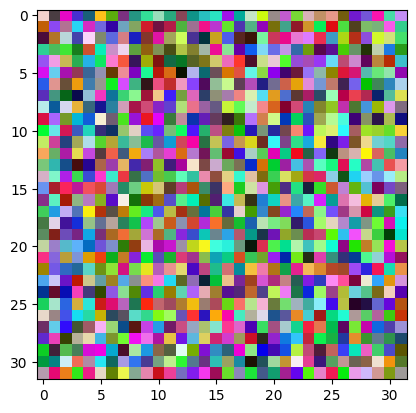

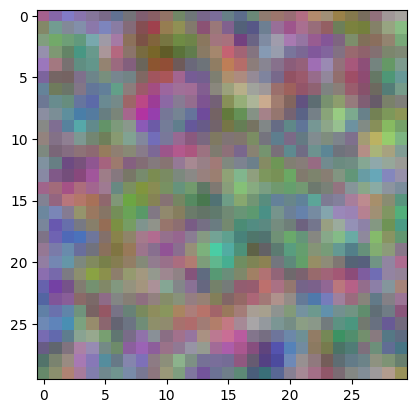

In [1]:
import torch
from matplotlib import pyplot as plt

tensor = torch.rand((1,3,32,32))

channel_connections = torch.eye(3)

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

blur = channel_connections.view(3,3,1,1)*filter

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

blurred = torch.nn.functional.conv2d(tensor,blur)

plt.imshow(blurred[0].permute(1,2,0))
plt.show()


# Zadanie 1

Zdefiniuj tensor 3x3x3x3 `rg_blur_to_b`.

Zakładając że mamy do czynienia z obrazem RGB, konwolucja na wyjściu zwracać ma obraz RGB, gdzie

* w kanale B zwracamy uśrednienie rozmytych (analogiczne jak wyżej) kanałów R, G obrazka wejściowego
* kanały R i G na wyjściu są zerami


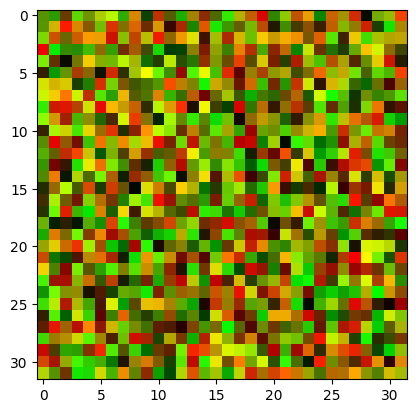

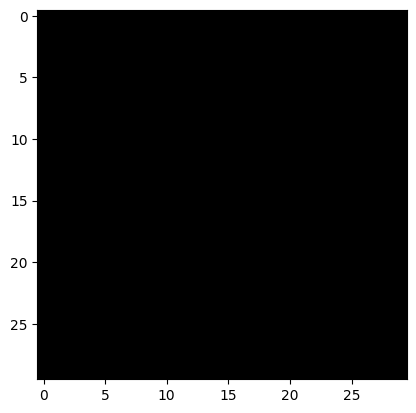

In [2]:
tensor = torch.rand((10,3,32,32))
tensor[:,2] = -7

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

channel_connections = torch.tensor([[1,0,0],
                                    [0,1,0],
                                    [0,0,1]])
rg_blur_to_b = channel_connections.view(3,3,1,1)*filter

rg_blur_to_b[0, :] = filter
rg_blur_to_b[1, :] = filter

blurred = torch.nn.functional.conv2d(tensor,rg_blur_to_b)

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

plt.imshow(blurred[0].permute(1,2,0))
plt.show()



# Warstwa konwolucyjna

W sieci konwolucyjnej będziemy wykorzystywać operację konwolucji tak jak opisane powyżej, w której uczone są tensor filtrów i bias dodawany do tensora na wyjściu. Warstwę z uczonymi parametrami definiuje klasa:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Pokrótce wyjaśnijmy parametry tej klasy na przykładzie filtra 2x2.

Poniższy obrazek reprezentuje lewy, górny róg mapy cech:

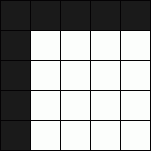

Na czerwono zaznaczymy pierwszy krok filtra przechodzącego po obrazie, na niebiesko drugi. Kolor fioletowy oznaczać będzie, że pola obejmowane przez filtry się pokrywają. Oznaczone pola przekładają się na dwa pierwsze piksele w wyjściowej mapie cech. Filtr 2x2 przy domyślnych parametrach będzie przechodził po obrazie następująco:

--------- Wejście ---------------------  Wyjście ----------

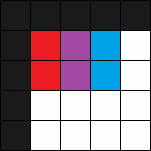
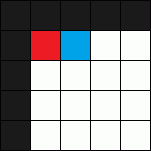


W kodzie deklarujemy w pierwszych trzech argumentach konstruktora `torch.nn.Conv2d`: liczbę kanałów wejściowych, liczbę kanałów wyjściowych, rozmiar filtra. Przy okazji, torchowa konwencja - aby podać rozmiar okna 2d możemy użyć jako argumentu zarówno krotki (x,y) jak i jednej liczby całkowitej, definiującej okno kwadratowe (x,x).

In [3]:
data_batch = torch.zeros(10,16,32,32)

#deklaracja warstwy: 16 kanałów wejściowych, 32 wyjściowych, filtr 2x2
conv_layer = torch.nn.Conv2d(16,32,2)

conv_layer(data_batch).shape

torch.Size([10, 32, 31, 31])

Jak widać, w wymiarach szerokości i wysokości, mapy cech zmniejszają się o 1.

Parametr `padding` pozwala na dodanie dodatkowych pikseli na krawędzi obrazka. Używany jest, aby zachować stałą szerokość i wysokość mapy cech po konwolucji. Dla `padding=1` pola obejmowane przez filtr będą wyglądać tak:

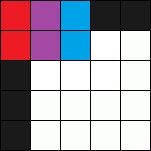

In [4]:
data_batch = torch.zeros(10,16,32,32)

conv_layer = torch.nn.Conv2d(16,16,2,padding=1)
print(conv_layer(data_batch).shape)

conv_layer = torch.nn.Conv2d(16,16,3,padding=1)
print(conv_layer(data_batch).shape)

torch.Size([10, 16, 33, 33])
torch.Size([10, 16, 32, 32])


Zauważ, że ze względu na symetryczny padding (dodawanie pikseli po obu stronach obrazu wejściowego) operacja zachowuje wysokość i szerokość tylko dla filtra o nieparzystym rozmiarze.

Parametr `stride` to krok filtra. Używany jest aby zredukować wymiary szerokości i wysokości pomiędzy kolejnymi warstwami konwolucyjnymi. `stride=2` daje nam downsampling do dwukrotnie mniejszej rozdzielczości, z wykorzystaniem uczącej się warstwy która może jednocześnie zmienić liczbę kanałów:

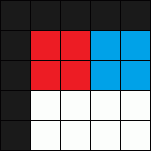


In [5]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,stride=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 16, 16])

Parametr `dilation` określa rozstaw filtra. Pozwala to obejmować filtrem piksele odległe od siebie o pewną stałą wartość. Szczególnie istotnym wykorzystaniem tego parametru jest użycie sekwencji warstw, w których kolejne wartości `dilation` to kolejne potęgi 2 - efektywnie skalując rozmiar pola obejmowanego przez całą architekturę wykładniczo z głębokością. Dla `dilation=2`:

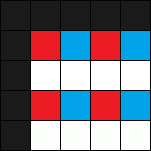

In [6]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,dilation=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 30, 30])

#Pooling

Zanim z warstw zbudujemy sieć, warto jeszcze wprowadzić operacje: poolingu i spłaszczania.

In [7]:
pool_layer =  torch.nn.MaxPool2d(2) #okno o stałym rozmiarze 2x2
adaptive_pool_layer = torch.nn.AdaptiveAvgPool2d((2,4)) #pooling adaptacyny
flatten_layer = torch.nn.Flatten()

data_batch = torch.zeros(10,3,128,128)
pool_layer(data_batch).shape, adaptive_pool_layer(data_batch).shape, flatten_layer(data_batch).shape

(torch.Size([10, 3, 64, 64]),
 torch.Size([10, 3, 2, 4]),
 torch.Size([10, 49152]))

Dwa standardowe typy poolingu to Max i Average pooling - zwracające odpowiednio maximum lub średnią z okna pooling.

Pooling o stałym rozmiarze okna pozwala nam na downsampling w wymiarach szerokości i wysokości bez potrzeby dodawania uczącej się warstwy. Przykładowo, okno 2x2 da nam redukcję szerokości i wysokości o dwa razy.

Pooling o adaptacyjnym rozmiarze okna pozwala na sprowadzenie wyniku konwolucji do stałego, zadanego rozmiaru wysokość/szerokość, co jest szczególnie przydatne jeśli chcemy przetwarzać obrazy o różnych rozmiarach. Zwykle wykorzystuje się go tylko w jednym miejscu, przed spłaszczeniem i ostatnią warstwą w pełni połączoną. Adaptacyjna warstwa poolingu z parametrem 2 bedzie redukować rozmiar w wymiarach wysokość, szerokośc do 2 na 2 - samodzielnie wyliczając dla każdego wejścia rozmiar okna potrzebny, żeby takie wyjście uzyskać.

Spłaszczanie zaś, jak sama nazwa wskazuje spłaszcza kształt tensora z (B, C, H, W) do (B, C\*H\*W)





Aby przejść do budowania i uczenia sieci konwolucyjnych, wczytamy zbiór CIFAR10. Zdefiniujemy też funkcje wykorzystane już na poprzednich laboratoriach:

In [8]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    test_dl: DataLoader,
    epochs: int,
    print_metrics: str = True,
):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    model.train()

    for epoch in range(epochs):
        for X_batch, y_batch in train_dl:
            y_pred = model(X_batch) # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            loss = loss_fn(y_pred, y_batch) # Policzenie funkcji straty

            loss.backward() # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step() # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad() # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()

        if print_metrics:
            model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
            with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
                train_loss, train_acc = validate(model, loss_fn, train_dl)
                test_loss, test_acc = validate(model, loss_fn, test_dl)

                train_losses.append(train_loss.item())
                train_accs.append(train_acc.item())
                test_losses.append(test_loss.item())
                test_accs.append(test_acc.item())
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"test loss = {test_loss:.3f} (acc: {test_acc:.3f})"
                )

    return train_losses, test_losses, train_accs, test_accs

100%|██████████| 170498071/170498071 [00:03<00:00, 44857652.51it/s]


Extracting cifar_root/cifar-10-python.tar.gz to cifar_root
Files already downloaded and verified


Zdefiniujmy teraz prostą sieć konwolucyjną.

# Zadanie 2

Uzupełnij kod klasy `SimpleCNN` tak, aby warstwy konwolucyjne nie zmieniały szerokości i wysokości mapy cech na wyjściu oraz aby wyjście w postaci tensora miało kształt zgodny z pożądanym `(batch_size, labels)`. Użyj rozmiaru filtra 3x3.

Zauważ, że o ile warstwy konwolucyjne nie muszą znać rozmiaru obrazu, o tyle spłaszczenie obrazu i podanie do warstwy w pełni połączonej wymusza na nas zdefiniowanie tego rozmiaru z góry. Sieć zbudowana w ten sposób przetwarzać będzie tylko obrazy o stałej szerokości i wysokości. Na potrzeby zadania, sieć ma być dostosowana do zbioru CIFAR: przyjmować obrazy RGB, 32x32 na wejściu i zwracać 10-elementowy wektor na wyjściu.

In [9]:
class SimpleCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3, channels, kernel_size=3, padding=1)
    self.relu1 = torch.nn.ReLU()
    self.maxpool = torch.nn.MaxPool2d(2)
    self.conv2 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.relu2 = torch.nn.ReLU()
    self.flatten = torch.nn.Flatten()
    self.fc = torch.nn.Linear(channels * channels * channels, labels)  # Calculated based on feature map size

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

Zweryfikuj, że sieć zwraca wlaściwy wymiar wyjścia i zmierz czas przetwarzania konwolucji na CPU i GPU

In [10]:
cnn_model = SimpleCNN(16, 10)
out = cnn_model(torch.zeros(128,3,32,32))
assert out.shape==(128,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())


32.3 ms ± 811 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

Sprawdźmy, że jesteśmy w stanie uczyć tę sieć:

In [ ]:
optimizer = optim.Adam(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 5, True)

# Zadanie 3

Zdefiniuj klasę `CNN`, sieć o strukturze

*   warstwa wejściowa in_conv o rozmiarze filtra 1x1 (transformacja liczby kanałów)
*   naprzemiennie - konwolucja, downsampling x2, konwolucja...
*   spłaszczenie wyniku do wektora
*   warstwa w pełni połączona

Klasa powinna być parametryzowalna tak, aby

*   umożliwić wybór rozmiaru filtra w warstwach konwolucji oprócz in_conv
*   umożliwić wybór zarówno liczby warstw, jak i liczby kanałów w poszczególnych warstwach konwolucyjnych
*   umożliwić wybór między downsamplingiem z użyciem poolingu a użyciem  warstwy konwolucyjnej




In [ ]:
!pip install torchinfo

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self, in_channels, out_size, conv_filter, conv_channels, use_pooling=True):
    super(CNN, self).__init__()
    # Initialize the input convolutional layer with a 1x1 filter
    self.in_conv = nn.Conv2d(in_channels, conv_channels[0], kernel_size=1)

    # Create the alternating convolutional and downsampling layers
    self.conv_layers = nn.ModuleList()
    for i in range(1, len(conv_channels)):
      self.conv_layers.append(nn.Conv2d(conv_channels[i-1], conv_channels[i], kernel_size=conv_filter))
      if use_pooling:
        self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
      else:
        self.conv_layers.append(nn.Conv2d(conv_channels[i], conv_channels[i], kernel_size=2, stride=2))

    # Calculate the size of the flattened features after all convolutions and pooling
    self.flat_features = self._get_flat_features(in_channels, conv_filter, conv_channels, use_pooling)

    # Fully connected layer
    self.fc = nn.Linear(self.flat_features, out_size)

  def forward(self, x):
    # Pass the input through the input convolutional layer
    x = F.relu(self.in_conv(x))

    # Pass the result through each convolutional and downsampling layer
    for layer in self.conv_layers:
      x = F.relu(layer(x))

    # Flatten the result
    x = x.view(x.size(0), -1)

    # Pass the flattened result through the fully connected layer
    x = self.fc(x)
    return x

  def _get_flat_features(self, in_channels, conv_filter, conv_channels, use_pooling):
    # Create a dummy input to calculate the size of the flattened features
    size = 32 # Assuming the input image size is 32x32
    dummy_input = torch.ones(5, in_channels, size, size)
    dummy_input = self.in_conv(dummy_input)
    for i in range(1, len(conv_channels)):
      dummy_input = F.relu(nn.Conv2d(conv_channels[i-1], conv_channels[i], kernel_size=conv_filter)(dummy_input))
      if use_pooling:
        dummy_input = F.max_pool2d(dummy_input, kernel_size=2, stride=2)
      else:
        dummy_input = F.relu(nn.Conv2d(conv_channels[i], conv_channels[i], kernel_size=2, stride=2)(dummy_input))
    dummy_input = dummy_input.view(dummy_input.size(0), -1)
    return int(dummy_input.shape[1])

Zweryfikuj działanie implementacji:

In [35]:
dummy_data = torch.zeros(37,3,32,32)

cnn_model = CNN(in_channels=3, out_size=15, conv_filter=5, conv_channels=[16, 32, 64], use_pooling=True) # utwórz CNN z: 15 etykietami wyjściowymi, filtrem 5x5, 3 warstwy conv z liczbą kanałów: 16,32,64, downsampling warstwą konwolucyjną
assert cnn_model(dummy_data).shape == (37,15)

cnn_model = CNN(in_channels=3, out_size=10, conv_filter=3, conv_channels=[8, 16, 32, 64], use_pooling=False) # utwórz CNN: 10 etykiet wyjściowych, filtr 3x3, 4 warstwy conv z liczbą kanałów: 8,16,32,64, downsampling warstwą poolingu
assert cnn_model(dummy_data).shape == (37,10)

# cnn1 = CNN(in_channels=3, out_size=10, conv_filter=5, conv_channels=[16, 32, 64], use_pooling=True)
# cnn2 = CNN(in_channels=3, out_size=10, conv_filter=3, conv_channels=[16, 32, 64], use_pooling=True)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())

34.8 ms ± 5.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Zadanie 4

Wykorzystaj zdefiniowaną klasę, aby przeprowadzić porównania:

1.   Uczenie z filtrem 3x3 a 5x5
2.   Uczenie z Max Pooling a warstwą konwolucją do downsamplingu
3.   Uczenie z trzema warstwami o rozmiarach 16,32,64, a uczenie z trzema warstwami o rozmiarach 32,32,32

Porównaj w kontekście metryki F-score, wyrysuj krzywe uczenia. Możesz tu korzystać z kodu napisanego na poprzednich laboratoriach.


In [37]:
import matplotlib.pyplot as plt

def compare_cnn_models(cnn1, cnn2, optimiser1, optimiser2, loss_fn, train_dl, test_dl, epochs):
    """
    Trains and compares two CNN models, visualizing the differences in learning plots.

    Args:
        cnn1 (nn.Module): The first CNN model to be trained.
        cnn2 (nn.Module): The second CNN model to be trained.
        optimiser1 (torch.optim.Optimizer): The optimizer to be used for training.
        optimiser2 (torch.optim.Optimizer): The optimizer to be used for training.
        loss_fn (torch.nn.Module): The loss function to be used for training.
        train_dl (torch.utils.data.DataLoader): The training data loader.
        test_dl (torch.utils.data.DataLoader): The test data loader.
        epochs (int): The number of training epochs.
    """

    # Train the first model
    train_l1, test_l1, train_a1, test_a1 = fit(
        model=cnn1, optimiser=optimiser1, loss_fn=loss_fn,
        train_dl=train_dl, test_dl=test_dl, epochs=epochs
    )

    # Train the second model
    train_l2, test_l2, train_a2, test_a2 = fit(
        model=cnn2, optimiser=optimiser2, loss_fn=loss_fn,
        train_dl=train_dl, test_dl=test_dl, epochs=epochs
    )
    return train_l1, test_l1, train_a1, test_a1, train_l2, test_l2, train_a2, test_a2

In [38]:
cnn1 = CNN(in_channels=3, out_size=10, conv_filter=5, conv_channels=[16, 32, 64], use_pooling=True)
cnn2 = CNN(in_channels=3, out_size=10, conv_filter=3, conv_channels=[16, 32, 64], use_pooling=True)
o1 = optim.Adam(cnn1.parameters(), lr=1e-3)
o2 = optim.Adam(cnn2.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


In [39]:
train_l1, test_l1, train_a1, test_a1, train_l2, test_l2, train_a2, test_a2 = compare_cnn_models(cnn1, cnn2, o1, o2, loss_fn, train_dl, test_dl, epochs=5)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [36]:
def visualize(
    train_l1, test_l1, train_a1, test_a1,
    train_l2, test_l2, train_a2, test_a2,
):
  # Training loss
  fig, (ax1, ax2) = plt.subplot(1, 2)

  ax1.set_title("CNN1")
  ax1.plot(list(range(len(train_l1))), train_l1, c="r", label="Loss dla zbioru treningowego")
  ax1.plot(list(range(len(test_l1))), test_l1, c="b", label="Loss dla zbioru testowego")

  ax2.set_title("CNN2")
  ax2.plot(list(range(len(train_l1))), train_l1, c="r", label="Loss dla zbioru treningowego")
  ax2.plot(list(range(len(test_l1))), test_l1, c="b", label="Loss dla zbioru testowego")

  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.title('Training Loss Comparison')
  plt.legend()

  # Training accuracy
  plt.subplot(1, 2, 2)
  plt.plot(train_a1, label=cnn1_name)
  plt.plot(train_a2, label=cnn2_name)
  plt.xlabel('Epoch')
  plt.ylabel('Training Accuracy')
  plt.title('Training Accuracy Comparison')
  plt.legend()

  plt.tight_layout()
  plt.show()
